# SARIMA Modeling

## Kevin Sheppard
### Advanced Financial Econometrics: Forecasting

### Background

Material available on [my site](https://www.kevinsheppard.com/teaching/mfe/advanced-financial-econometrics-forecasting/).

More detail in [pre-recorded lectures](https://www.youtube.com/playlist?list=PLVR_rJLcetzmES8tqjgqlQw1Vx2IKMVot).

### Viewing as a Presentation

This notebook has been written with RISE in mind. To view it as a presentation, install RISE using pip install RISE and then press ALT + R to enter slides model.


# Updating statsmodels

Some of the code in this notebook requires a recent version statsmodels (as of May 2020). If you already have statsmodels 0.12.0 or later, you can ignore this step.

You can install the development version of statsmodels using the command

```
pip install statsmodels --upgrade --pre --find-links https://7933911d6844c6c53a7d-47bd50c35cd79bd838daf386af554a83.ssl.cf2.rackcdn.com/ 
```

This is a repository where pre-release versions are stored.

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import seaborn as sns
sns.set_style("darkgrid")
# These values are optimized for full-screen on a high-resolution monitor
plt.rc("figure", figsize=(32,12))
plt.rc("font", size=28)
plt.rc("lines", linewidth=4)

# Load some data

We will use the 432-observation M4 data to explore ES.

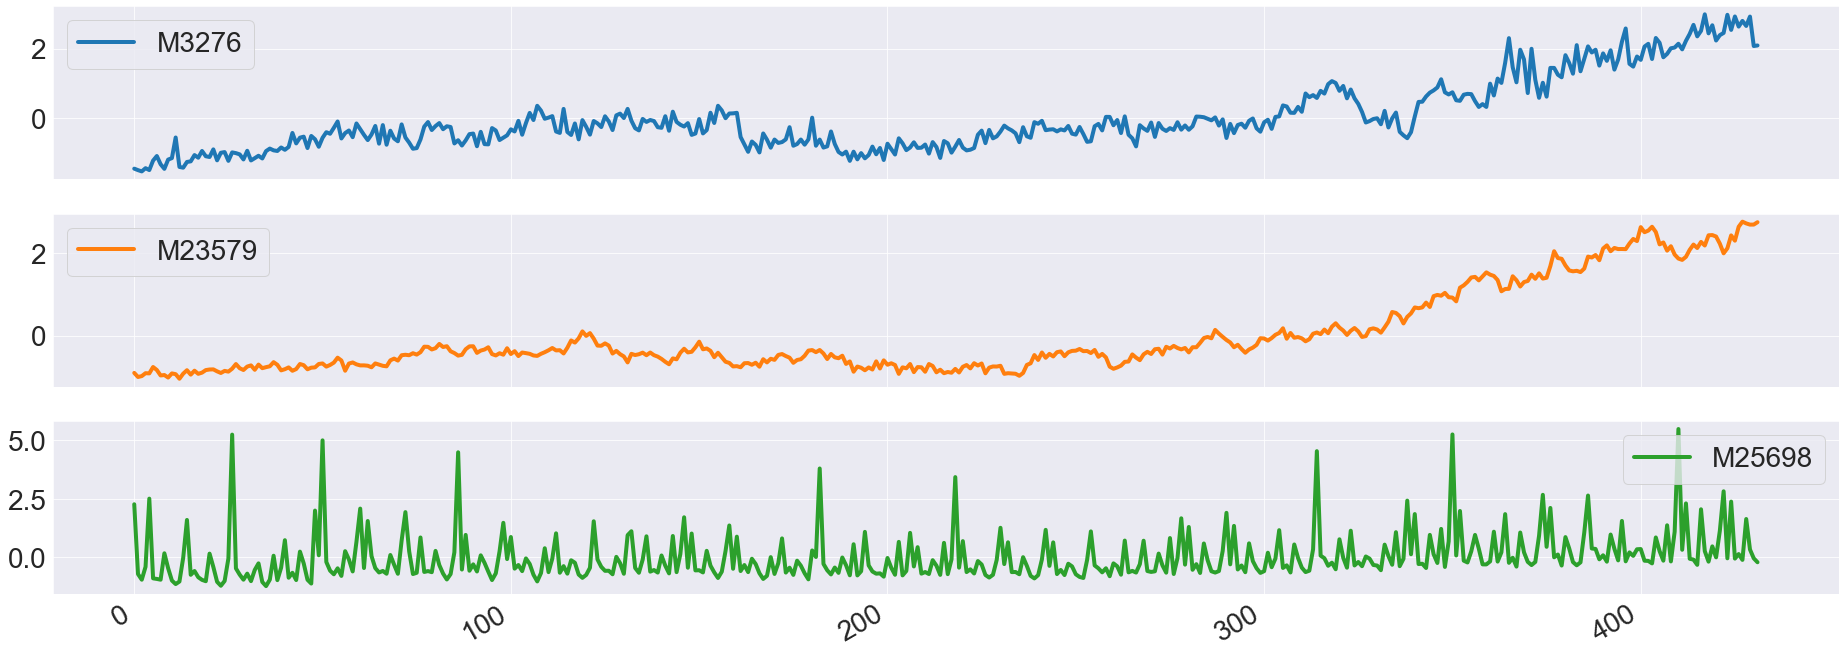

In [2]:
df: pd.DataFrame = pd.read_hdf("./monthly-data.h5", f"nobs_432")
data = df[["M3276","M23579","M25698"]]
data.index = np.arange(data.shape[0])
std_data = (data - data.mean()) / data.std()
plts = std_data.plot(subplots=True)

# Non-seasonal modeling

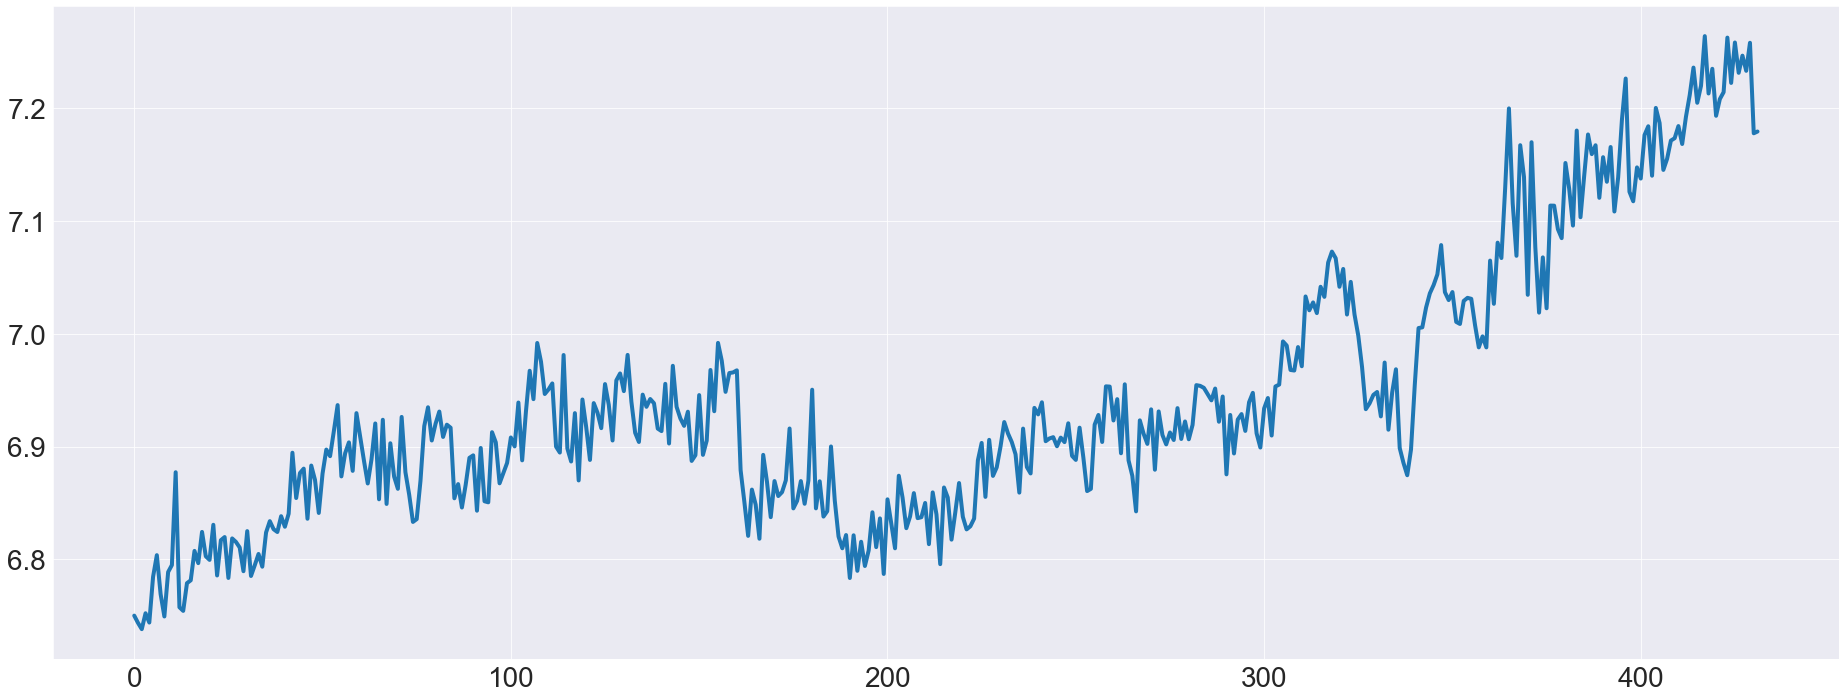

In [3]:
y = np.log(data["M3276"])
_ = y.plot()

# Time Trend and AR(1)

We start with the model

$$ Y_t = \delta_0 + \delta_1 t + \phi Y_{t-1} + \epsilon_t $$

In [4]:
ar1_trend = SARIMAX(y, order=(1,0,0), trend="ct").fit(maxiter=250)
ar1_trend.summary()

c:\git\statsmodels\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 828.258
Date:                Fri, 08 May 2020   AIC                          -1648.515
Time:                        10:32:01   BIC                          -1632.242
Sample:                             0   HQIC                         -1642.091
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8916      0.166      5.376      0.000       0.567       1.217
drift       9.836e-05    2.3e-05      4.271      0.000    5.32e-05       0.000
ar.L1          0.8686      0.024     35.550      0.000       0.821       0.917
sigma2         0.0013   8.38e-05     15.075      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      468.41   Jarque-Bera (JB):                 2.18
Prob(Q):                              0.00   Prob(JB):                         0.34
Heteroskedasticity (H):               1.31   Skew:                             0.14
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARMA(1,1) with a Trend

We next estimate 

$$ Y_t = \delta_0 + \delta_1 t + \phi Y_{t-1} + \theta \epsilon_{t-1} + \epsilon_t $$

In [5]:
y = np.log(data["M3276"])
arma11_trend = SARIMAX(y, order=(1,0,1), trend="ct").fit(maxiter=250)
arma11_trend.summary()

c:\git\statsmodels\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 871.818
Date:                Fri, 08 May 2020   AIC                          -1733.637
Time:                        10:32:02   BIC                          -1713.295
Sample:                             0   HQIC                         -1725.606
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3852      0.088      4.385      0.000       0.213       0.557
drift       4.312e-05   1.11e-05      3.901      0.000    2.15e-05    6.48e-05
ar.L1          0.9433      0.013     72.878      0.000       0.918       0.969
ma.L1         -0.5243      0.040    -13.111      0.000      -0.603      -0.446
sigma2         0.0010    6.6e-05     15.096      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      242.60   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               1.49   Skew:                             0.14
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Information Criteria: AIC, BIC & HQIC

The ICs are designed so that lower values indicate a model that fits better, controlling for the number of parameters. We see that ARMA(1,1) has a much lower BIC than that AR(1).

In [6]:
pd.DataFrame([[ar1_trend.aic, ar1_trend.hqic, ar1_trend.bic],
              [arma11_trend.aic, arma11_trend.hqic, arma11_trend.bic]],
            columns=["AIC", "HQIC", "BIC"], index=["AR(1)", "ARMA(1,1)"])


,AIC,HQIC,BIC
AR(1),-1648.515296,-1642.090503,-1632.241594
"ARMA(1,1)",-1733.636965,-1725.605974,-1713.294838


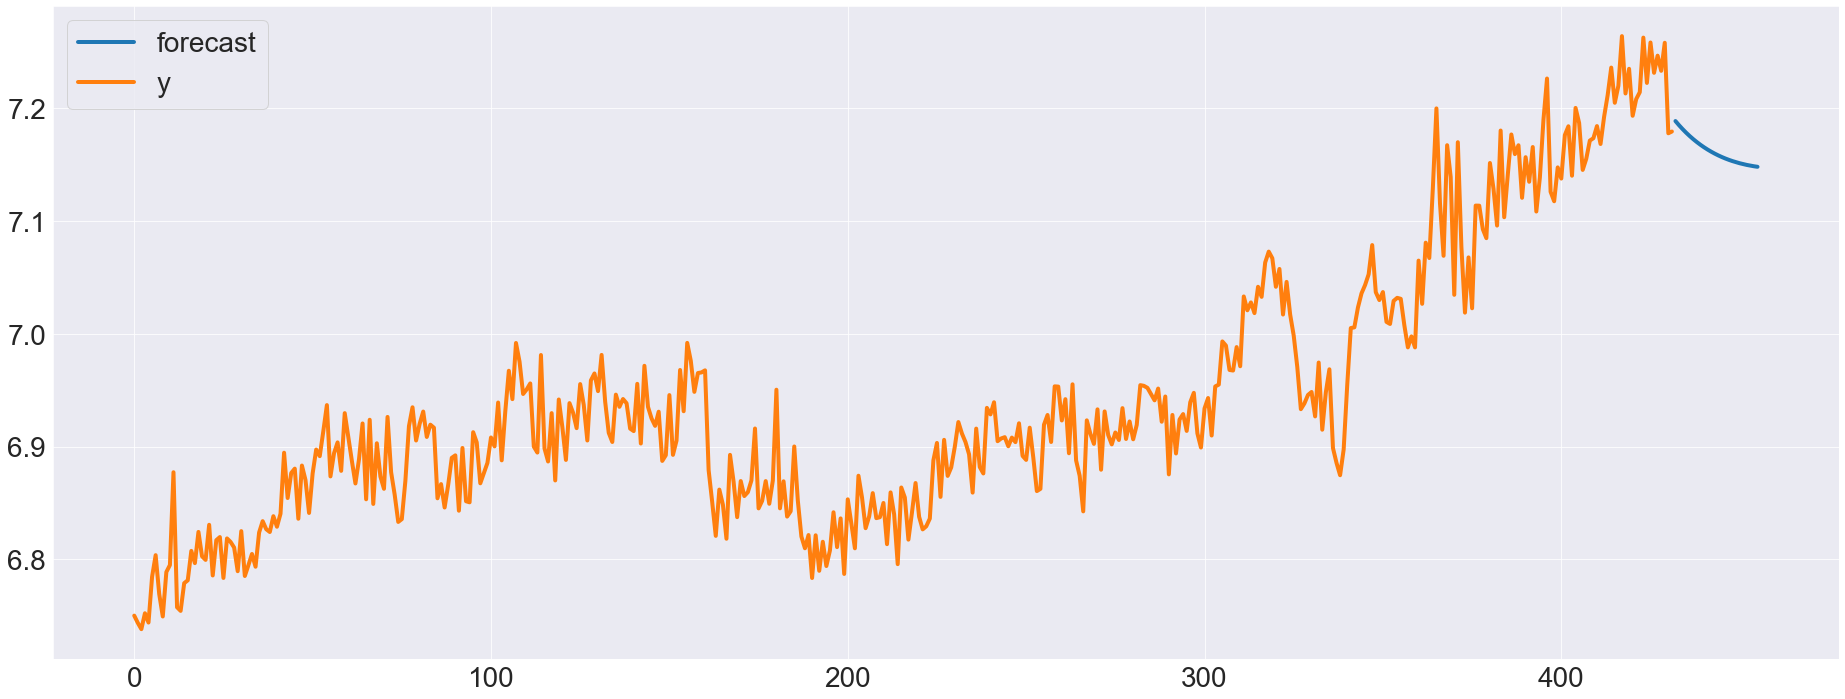

In [7]:
def plot_forecast(y, forecast, tail=None):
    df = pd.DataFrame({"forecast":pd.Series(list(np.nan * y) + list(forecast)),
                   "y": y})
    if tail is not None:
        df = df.tail(tail)
    df.plot()
plot_forecast(y, arma11_trend.forecast(24))

# ARIMA(1, 1, 1)

The next model is

$$ \begin{align*} 
(1-\phi_1 L) (1-L) Y_t = & \delta_0 \theta \epsilon_{t-1} + \epsilon_t \\
\Delta Y_t = & \delta_0 + \phi \Delta Y_{t-1} + \theta \epsilon_{t-1} + \epsilon_t \\
\end{align*}
$$

$\Delta Y_t$ is used since $d=1$.


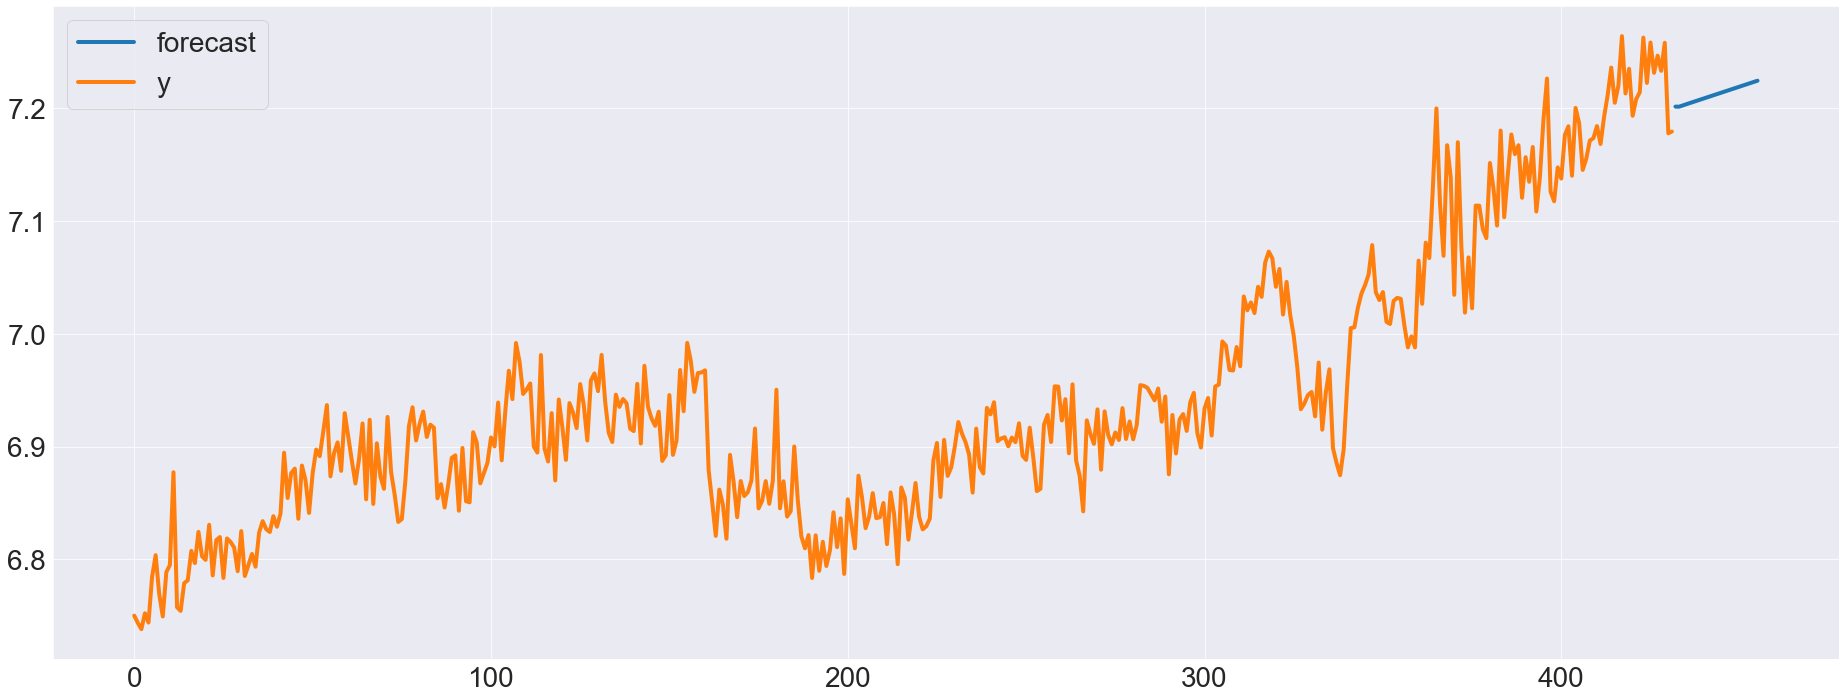

In [8]:
arima_111 = SARIMAX(y, order=(1, 1, 1), trend="c").fit(maxiter=250)
arima_111.summary()
plot_forecast(y, arima_111.forecast(24))

# ARIMA(0, 1, 1)

$$ \Delta Y_t = \delta_0 +  \theta \epsilon_{t-1} + \epsilon_t $$


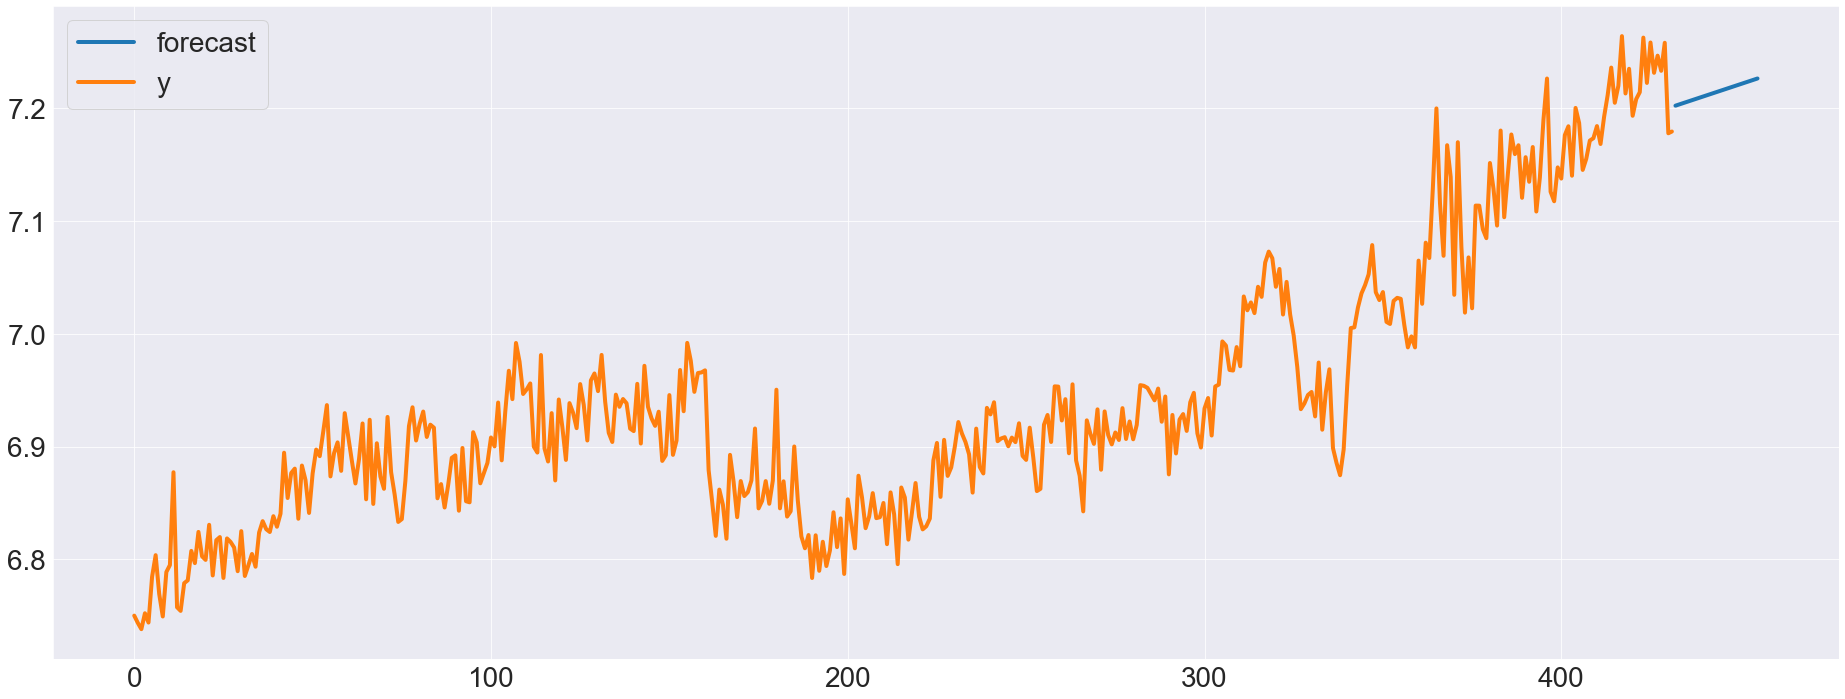

In [9]:
arima_011 = SARIMAX(y, order=(0, 1, 1), trend="c").fit(maxiter=250)
arima_011.summary()
plot_forecast(y, arima_011.forecast(24))

# ARIMA(0,1,1) without a constant

$$ \Delta Y_t =  \theta \epsilon_{t-1} + \epsilon_t $$


In [10]:
arima_011_nc = SARIMAX(y, order=(0, 1, 1), trend="n").fit(maxiter=250)
arima_011_nc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 871.865
Date:                Fri, 08 May 2020   AIC                          -1739.729
Time:                        10:32:05   BIC                          -1731.597
Sample:                             0   HQIC                         -1736.518
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5494      0.034    -16.363      0.000      -0.615      -0.484
sigma2         0.0010   6.71e-05     15.260      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      240.24   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               1.48   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

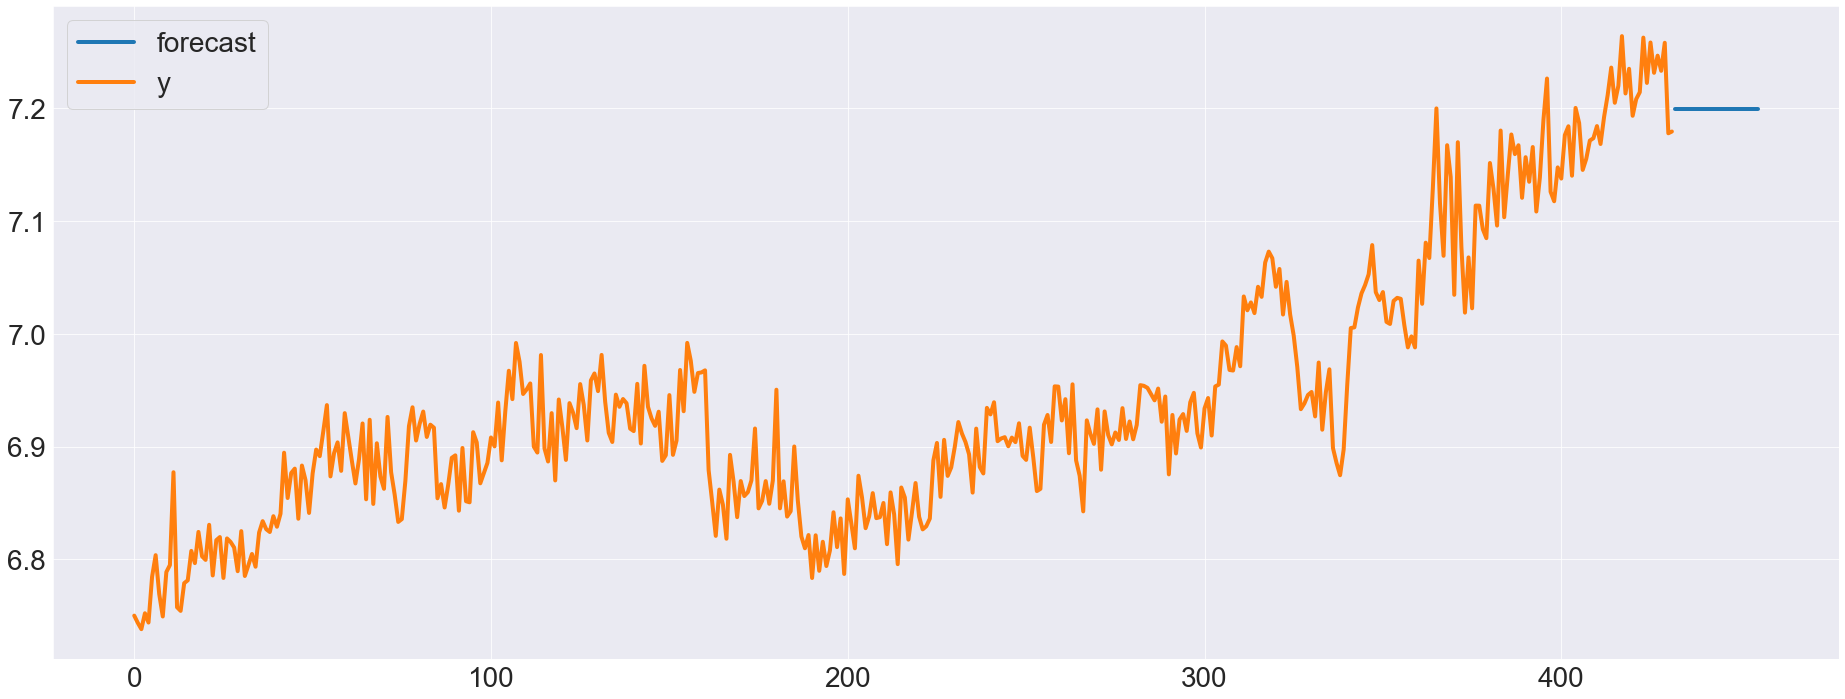

In [11]:
plot_forecast(y, arima_011_nc.forecast(24))

# Seasonal

We finally show how to fit models with seasonal dummies and using seasonal differencing.

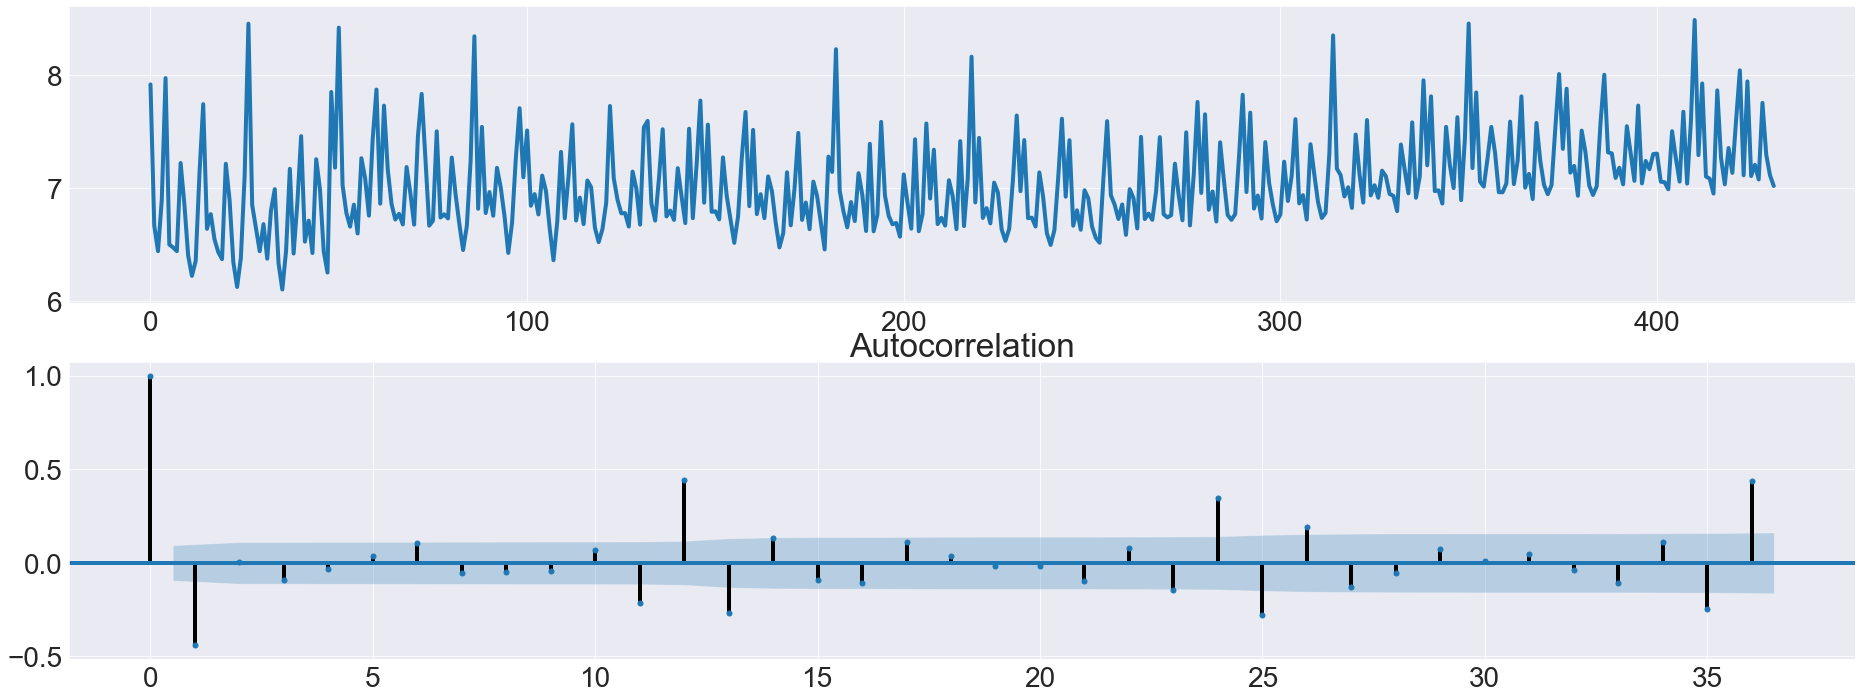

In [12]:
y = np.log(data["M25698"])
fig, axes = plt.subplots(2, 1)
y.plot(ax=axes[0])
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
_ = plot_acf(y.diff().dropna(), lags=36, ax=axes[1])

## Constructing Seasonal Dummies

Seasonal dummies are easy to build using `pd.get_dummies` and a `categorical` Series. The categorical series is used to store categorical data. We first construct the seasonal indicators using $\!\!\mod(t,12)$ for each time period. It is easiest to construct the dummies for both the in-sample and the out-of-sample periods, which is why it is `y.shape[0] + 24`.

In [13]:
seasonals = np.arange(y.shape[0] + 24)
seasonals = seasonals % 12
seasonals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9

`pd.get_dummies` takes the argument `drop_first` which lets us avoid the dummy variable trap. 

In [14]:
from pandas import get_dummies
dummies = get_dummies(pd.Series(seasonals, dtype="category"), drop_first=True)
dummies.columns = [f"s{i}" for i in range(2, 13)] 
dummies.head(14)

,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0


# ARIMA(1, 0, 0) with seasonal dummies

$$ Y_t = \delta_0 + \delta_1 t + \phi Y_{t-1} + \sum_{i=2}^{12} \gamma_i I_{S_i} + \epsilon_t $$

In [15]:
ar1_seasonal_dummies = SARIMAX(y, exog=dummies.iloc[:y.shape[0]], order=(1, 0 , 0), trend="c").fit(maxiter=250)
ar1_seasonal_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 M25698   No. Observations:                  432
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -107.374
Date:                Fri, 08 May 2020   AIC                            242.748
Time:                        10:32:10   BIC                            299.706
Sample:                             0   HQIC                           265.234
                                - 432                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7980      0.303     15.832      0.000       4.204       5.392
s2             0.2563      0.070      3.648      0.000       0.119       0.394
s3             0.6808      0.056     12.074      0.000       0.570       0.791
s4             0.1153      0.083      1.397      0.162      -0.046       0.277
s5             0.4811      0.068      7.050      0.000       0.347       0.615
s6            -0.1097      0.115     -0.958      0.338      -0.334       0.115
s7            -0.0322      0.137     -0.236      0.813      -0.300       0.235
s8            -0.1780      0.125     -1.420      0.156      -0.424       0.068
s9             0.3666      0.102      3.591      0.000       0.167       0.567
s10            0.1354      0.176      0.769      0.442      -0.210       0.480
s11           -0.1601      0.112     -1.434      0.152      -0.379       0.059
s12            0.0495      0.056      0.883      0.377      -0.060       0.159
ar.L1          0.3056      0.044      7.018      0.000       0.220       0.391
sigma2         0.0962      0.005     17.546      0.000       0.085       0.107
===================================================================================
Ljung-Box (Q):                      239.70   Jarque-Bera (JB):                48.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
forecast = ar1_seasonal_dummies.forecast(24, exog=dummies.iloc[y.shape[0]:])
forecast

432    6.928012
433    7.171714
434    7.592380
435    7.025697
436    7.391069
437    6.800175
438    6.877663
439    6.731839
440    7.276494
441    7.045245
442    6.749739
443    6.959373
444    6.909859
445    7.166166
446    7.590684
447    7.025179
448    7.390910
449    6.800126
450    6.877649
451    6.731834
452    7.276493
453    7.045245
454    6.749739
455    6.959372
dtype: float64

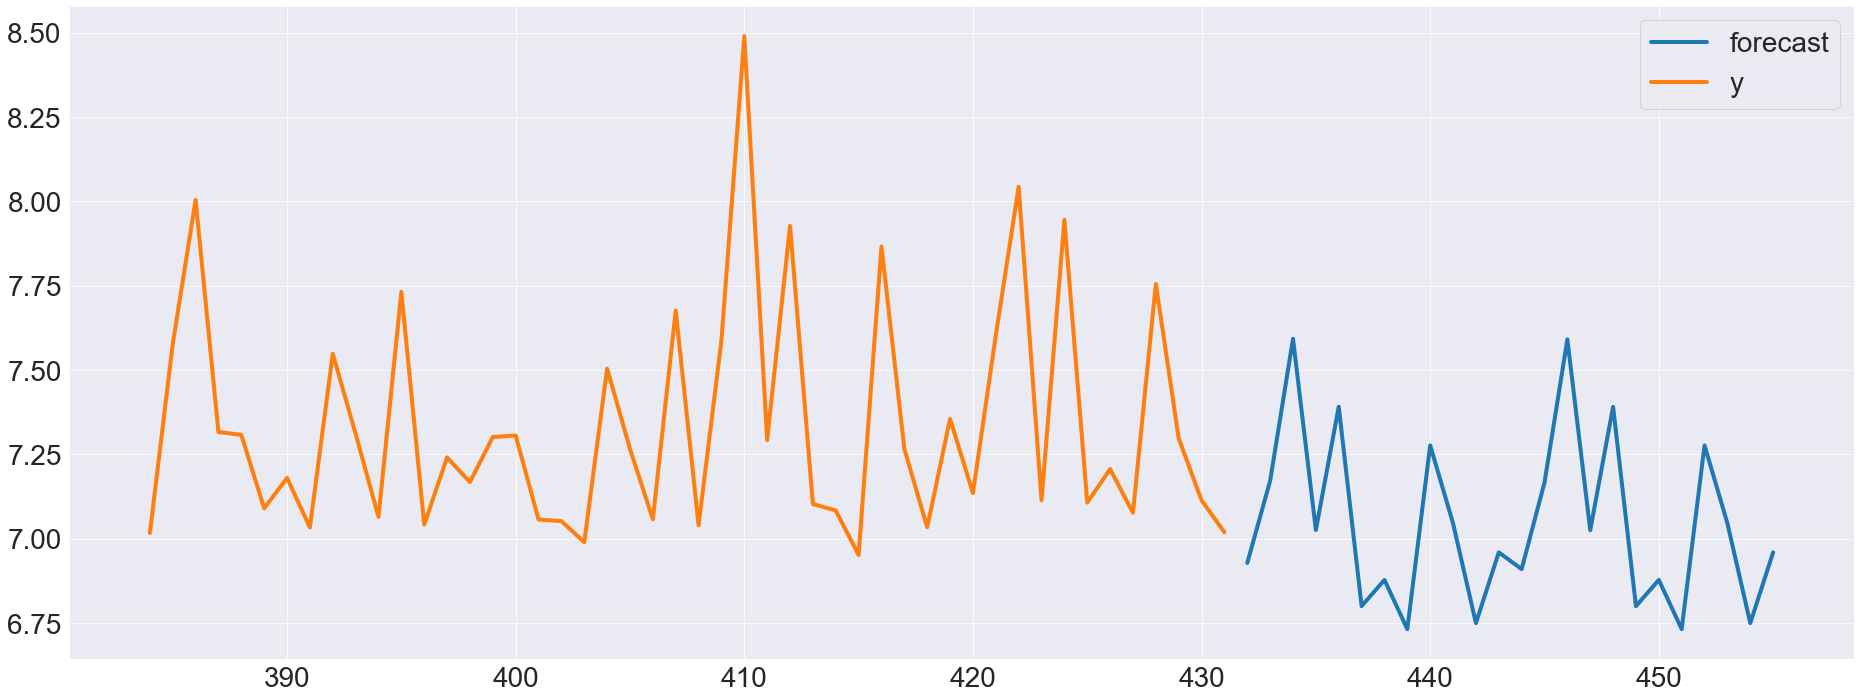

In [17]:
plot_forecast(y, forecast, 72)

# SARIMA$(0,0,0)\times(0,1,0)_{12}$


Finally we fit a SARIMA with a single difference.  Note that the only free parameter is the constant in the model.

$$ \Delta_{12} Y_t = \delta_0 + \epsilon_t $$


In [18]:
arima_000_010 = SARIMAX(y,order=(0,0,0), seasonal_order=(0, 1,0, 12), trend="c").fit()
arima_000_010.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                   M25698   No. Observations:                  432
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -210.775
Date:                  Fri, 08 May 2020   AIC                            425.550
Time:                          10:32:11   BIC                            433.630
Sample:                               0   HQIC                           428.743
                                  - 432                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0152      0.020      0.780      0.436      -0.023       0.054
sigma2         0.1597      0.005     30.443      0.000       0.149       0.170
===================================================================================
Ljung-Box (Q):                      152.93   Jarque-Bera (JB):               822.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
forecast = arima_000_010.forecast(24)
forecast

432    7.150139
433    7.617987
434    8.058335
435    7.128758
436    7.960502
437    7.122053
438    7.221591
439    7.091860
440    7.770104
441    7.312457
442    7.128882
443    7.033996
444    7.165367
445    7.633214
446    8.073563
447    7.143986
448    7.975729
449    7.137280
450    7.236819
451    7.107087
452    7.785331
453    7.327685
454    7.144109
455    7.049223
dtype: float64

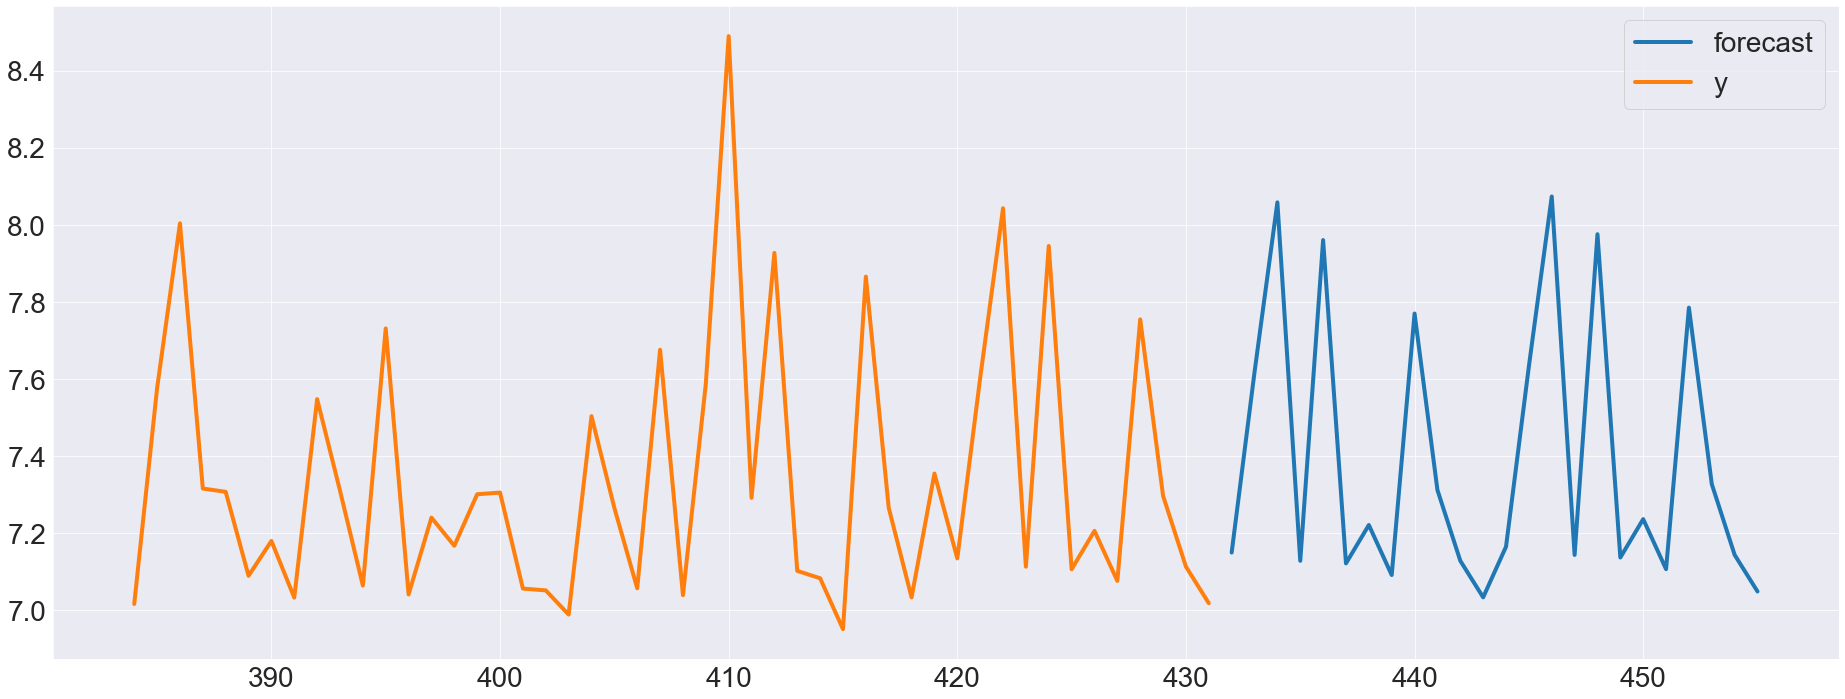

In [20]:
plot_forecast(y, forecast, 72)